# Tweet Sentiment Analysis Using NLP

## Business Problem

- ~~Google data scientist, trying to gather data about how Google's products and services compare to Apple and how people feel about Google compared to Apple, trying to determine what they can use to improve since Apple is popular~~ include in next steps
- Using a model to predict the sentiment of consumers between Apple and Google products and services, we can see the preferences of consumers and try to highlight certain features between competitors to further improve Google products and services
- Easier to build model that can do this for us instead of individually reviewing thousands of reviews and survey responses. This is quicker and more efficient to make more informed decisions and to be able to respond to customers in a more timely manner (social media team, customer support team)
- By creating a model that can predict consumer sentiment, we can make decisions to maximize sales and customer satisfaction when launching new products and services as well, as well as track sentiment over time
- Analyze feelings of our target audience towards our brand

## Data / EDA

Packages

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import nltk
from nltk import FreqDist
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from wordcloud import WordCloud
from xgboost import XGBClassifier

Loading in dataset. Data contains sample of tweets from Twitter that have been labelled for us by human raters.

In [2]:
df = pd.read_csv('data/twitter_product_emotions.csv')

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
print(df.shape)
df.info()

(8721, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


Value counts in each column

In [4]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

Just looking at the distribution of tweets, it looks like in general, more people comment about Apple products and iOS than about Google and Android. In our analysis later on, we can make a note of this and investigate into why more people tend to comment about Apple on social media.

In [5]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: emotion_in_tweet_is_directed_at, dtype: int64

Get rid of "I can't tell" tweets. For now these extra tweets will not be helpful in trying to create a model that can predict tweet sentiment.

In [6]:
unknown_emotion = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"].index

df.drop(unknown_emotion, inplace=True)
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5410
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

Create new dataframe with only positive and negative emotion entries

In [8]:
# note to self: clean up code here later
neutral = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "No emotion toward brand or product"].index

sentiment_df = df
sentiment_df.drop(neutral, inplace=True)
print(sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())
sentiment_df.head()

Positive emotion    2869
Negative emotion     545
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Examining most common words in tweets. To do this, we need to tokenize tweets

In [9]:
def tweet_tokenizer(dataframe):
    """
    Takes in a dataframe of Twitter tweets stored in a dataframe,
    tokenizes each tweet, stores it into a list, and filters out 
    stopwords, punctuation, and other text symbols. Returns list with
    filtered text data.
    """
    tt = TweetTokenizer()
    tweet_tokens_raw = dataframe['tweet_text'].apply(tt.tokenize)
    tweet_tokens = sum(tweet_tokens_raw, [])
    
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['@mention', '�']
    tweet_tokens = [w.lower() for w in tweet_tokens if w not in stopwords_list]
    
    return tweet_tokens

In [18]:
# need to integrate and update tweet_tokenizer() function
tokenizer = TweetTokenizer()
sentiment_df['tokens'] = [tokenizer.tokenize(text) for text in sentiment_df['tweet_text']]
print(sentiment_df['tokens'].head())

0    [., @wesley83, I, have, a, 3G, iPhone, ., Afte...
1    [@jessedee, Know, about, @fludapp, ?, Awesome,...
2    [@swonderlin, Can, not, wait, for, #iPad, 2, a...
3    [@sxsw, I, hope, this, year's, festival, isn't...
4    [@sxtxstate, great, stuff, on, Fri, #SXSW, :, ...
Name: tokens, dtype: object


In [24]:
sentiment_df['lower_tokens'] = sentiment_df['tokens'].apply(lambda x: [w.lower() for w in x])
sentiment_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tokens,lower_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[., @wesley83, I, have, a, 3G, iPhone, ., Afte...","[., @wesley83, i, have, a, 3g, iphone, ., afte..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[@jessedee, know, about, @fludapp, ?, awesome,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[@swonderlin, can, not, wait, for, #ipad, 2, a..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...","[@sxsw, i, hope, this, year's, festival, isn't..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW, :, ...","[@sxtxstate, great, stuff, on, fri, #sxsw, :, ..."


In [25]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['@mention', '�']
sentiment_df['no_stops'] = df['lower_tokens'].apply(lambda x: [w for w in x if w not in stopwords_list])
sentiment_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tokens,lower_tokens,no_stops
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[., @wesley83, I, have, a, 3G, iPhone, ., Afte...","[., @wesley83, i, have, a, 3g, iphone, ., afte...","[@wesley83, 3g, iphone, 3, hrs, tweeting, #ris..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[@jessedee, know, about, @fludapp, ?, awesome,...","[@jessedee, know, @fludapp, awesome, ipad, iph..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[@swonderlin, can, not, wait, for, #ipad, 2, a...","[@swonderlin, wait, #ipad, 2, also, sale, #sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...","[@sxsw, i, hope, this, year's, festival, isn't...","[@sxsw, hope, year's, festival, crashy, year's..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW, :, ...","[@sxtxstate, great, stuff, on, fri, #sxsw, :, ...","[@sxtxstate, great, stuff, fri, #sxsw, marissa..."


In [20]:
# this cell uses old function, need to find way to simplify this cell and create freq dist with updated function
sentiment_tweets = tweet_tokenizer(sentiment_df)
sentiment_freqdist = FreqDist(sentiment_tweets)
sentiment_freqdist.most_common(10)

[('#sxsw', 3426),
 ('link', 1264),
 ('ipad', 1163),
 ('rt', 1069),
 ('apple', 798),
 ('google', 720),
 ('2', 636),
 ('iphone', 591),
 ('store', 569),
 ('i', 549)]

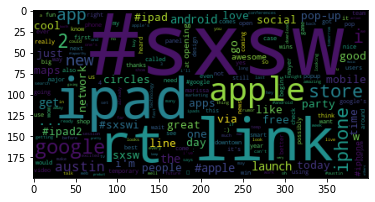

In [22]:
# sentiment_tweets = sentiment_df.str.join(' ')
# sentiment_tweets = ' '.join(sentiment_tweets)
# sentiment_tweets = sentiment_tweets.split(' ')
# fdist = FreqDist(sentiment_tweets)
wordcloud = WordCloud().generate_from_frequencies(sentiment_freqdist)

plt.imshow(wordcloud)
plt.show()

## Analysis

Splitting dataset into training and test sets before fitting models.

In [35]:
X = sentiment_df['no_stops'].str.join(' ')
y = sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [36]:
X_train

184                        #ipad 2 takes #sxsw video link
210     hobo shotgun video game coming ipad iphone use...
6906    #tech even begins #apple wins #sxsw past week ...
857     think might go weekend without seeing ipad cas...
4690    andrew k prx equates homogeneity apple ecosyst...
                              ...                        
5277    rt #sxsw apple schools marketing experts link via
7873    woohoo rt go game launches do-it-yourself ipho...
4240    left brain search google right brain search x ...
2703    joined heaving river flow see marissa mayer go...
3259    y'all seen temp apple store going downtown #sx...
Name: no_stops, Length: 2731, dtype: object

In [42]:
# may not be necessary, just testing to see if TF-ID vectorizer works
tf_vectorizer = TfidfVectorizer()
tf_vectorizer.fit(X_train)
tf_train = tf_vectorizer.transform(X_train)
tf_test = tf_vectorizer.transform(X_test)

In [41]:
# running first simple test model
from sklearn.linear_model import LogisticRegression

logreg_test = LogisticRegression(max_iter=1000)
tfidf_vectorizer = TfidfVectorizer()

lr_pipe = make_pipeline(tfidf_vectorizer, logreg_test)

scores = cross_val_score(lr_pipe, X_train, y_train)
print(scores)
print(np.mean(scores))

[0.85374771 0.84615385 0.84615385 0.84981685 0.84065934]
0.8473063195183853
